In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from concurrent.futures import ThreadPoolExecutor, as_completed
import json
import nltk
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import numpy as np
import seaborn as sns
import torch
from torch.cuda.amp import autocast

In [2]:
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ajaym\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def clean_text(text):
    """
    Clean text by removing encoded characters, normalizing spaces, and fixing punctuation.

    Args:
        text (str): The raw text to be cleaned.

    Returns:
        str: The cleaned text.
    """
    text = text.encode('ascii', 'ignore').decode('ascii')
    text = text.replace('\xa0', ' ')
    text = text.replace('\x92', "'")
    text = text.replace('\x93', '"')
    text = text.replace('\x94', '"')
    text = re.sub(r'\\x[0-9A-Fa-f]{2}', '', text)

    text = re.sub(r'(www\.[a-zA-Z0-9-]+\.[a-zA-Z0-9]+)', r'\1_URL_', text)
    text = re.sub(r'Item\s*(\d+[A-Za-z]*)\.', r'Item_\1_', text)
    text = re.sub(r'U\.S\.', r'US_', text)
    text = re.sub(r'Inc\.', r'Inc_', text)
    text = re.sub(r'Corp\.', r'Corp_', text)
    text = re.sub(r'Dec\.', r'Dec_', text)

    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\s*\.\s*', '. ', text)
    text = re.sub(r'\s*,\s*', ', ', text)
    text = re.sub(r'\s*;\s*', '; ', text)
    text = re.sub(r'\s*:\s*', ': ', text)
    text = re.sub(r'\s+([,.;:])', r'\1', text)
    text = re.sub(r'(?<=[.!?])(?=\S)', ' ', text)
    text = re.sub(r'\.+', '.', text)

    return text.strip()


In [ ]:
def split_sentences(text):
    """
    Splits the input text into sentences using NLTK, with additional pre- and post-processing 
    to clean text and handle special cases.

    Args:
        text (str): The input text string to split.

    Returns:
        list: A list of processed sentences.
    """
    cleaned_text = clean_text(text)
    sentences = sent_tokenize(cleaned_text)

    processed_sentences = []
    for sentence in sentences:
        sentence = sentence.replace('Item_', 'Item ').replace('_', '.')
        sentence = sentence.replace('US_', 'U.S.')
        sentence = sentence.replace('Inc_', 'Inc.')
        sentence = sentence.replace('Corp_', 'Corp.')
        sentence = sentence.replace('Dec_', 'Dec.')
        sentence = sentence.replace('_URL_', '.')
        sentence = sentence.strip()
        if len(sentence) > 5:
            processed_sentences.append(sentence)

    final_sentences = []
    i = 0
    while i < len(processed_sentences):
        current = processed_sentences[i]
        if current.endswith((';', ':')) or current.startswith(('•', '-')):
            final_sentences.append(current)
            i += 1
        elif i + 1 < len(processed_sentences) and not current.endswith(('.', '!', '?')):
            final_sentences.append(current + ' ' + processed_sentences[i + 1])
            i += 2
        else:
            final_sentences.append(current)
            i += 1

    return final_sentences


In [ ]:
def converttotext(url):
    """
    Extracts and processes the Item 1A section from a 10-K SEC filing given its URL.

    Args:
        url (str): The URL to the SEC 10-K filing.

    Returns:
        list: A list of sentences extracted from the Item 1A section.
    """
    
    headers = {'User-Agent':'Sample Company Name AdminContact@<sample company domain>.com','Accept-Encoding':'gzip, deflate','Host':'www.sec.gov'}

    r = requests.get(url, headers=headers)

    raw_10k = r.text

    doc_start_pattern = re.compile(r'<DOCUMENT>')
    doc_end_pattern = re.compile(r'</DOCUMENT>')
    type_pattern = re.compile(r'<TYPE>[^\n]+')

    doc_start_is = [x.end() for x in doc_start_pattern.finditer(raw_10k)]
    doc_end_is = [x.start() for x in doc_end_pattern.finditer(raw_10k)]

    doc_types = [x[len('<TYPE>'):] for x in type_pattern.findall(raw_10k)]

    document = {}
    
    for doc_type, doc_start, doc_end in zip(doc_types, doc_start_is, doc_end_is):
        if doc_type == '10-K':
            document[doc_type] = raw_10k[doc_start:doc_end]

    regex = re.compile(r'(>Item(\s|&#160;|&nbsp;)(1A|1B|3|7A|7|8)\.{0,1})|(ITEM\s(1A|1B|3|7A|7|8))')

    matches = regex.finditer(document['10-K'])

    test_df = pd.DataFrame([(x.group(), x.start(), x.end()) for x in matches])

    test_df.columns = ['item', 'start', 'end']
    test_df['item'] = test_df.item.str.lower()
    test_df.head()
    test_df.replace('&#160;',' ',regex=True,inplace=True)
    test_df.replace('&nbsp;',' ',regex=True,inplace=True)
    test_df.replace(' ','',regex=True,inplace=True)
    test_df.replace('\.','',regex=True,inplace=True)
    test_df.replace('>','',regex=True,inplace=True)

    pos_dat = test_df.sort_values('start', ascending=True).drop_duplicates(subset=['item'], keep='last')
    pos_dat.set_index('item', inplace=True)

    item_1a_raw = document['10-K'][pos_dat['start'].loc['item1a']:pos_dat['start'].loc['item1b']]
    item_1a_content = BeautifulSoup(item_1a_raw, 'lxml')

    # item_7_raw = document['10-K'][pos_dat['start'].loc['item7']:pos_dat['start'].loc['item7a']]
    # item_7_content = BeautifulSoup(item_7_raw, 'lxml')

    item_1a_text = item_1a_content.get_text()
    # item_7_text = item_7_content.get_text()

    sentences = split_sentences(item_1a_text)
    # sentences = split_sentences(item_7_text)
    
    return sentences

In [ ]:
def calculate_average_and_std_esg(sentences, nlp):
    """
    Calculate the average and standard deviation of ESG scores (Environmental, Social, Governance) from a set of sentences.

    Args:
        sentences (str): The input text containing ESG-related content.
        nlp (function): A natural language processing function that extracts ESG scores from the text.

    Returns:
        dict: A dictionary with the average and standard deviation of ESG scores for each category.
    """
    results = nlp(sentences)

    # Extract scores for each category
    environment_scores = [entry['score'] for entry in results if entry['label'] == 'Environmental']
    social_scores = [entry['score'] for entry in results if entry['label'] == 'Social']
    governance_scores = [entry['score'] for entry in results if entry['label'] == 'Governance']

    # Calculate averages
    environment_score_avg = sum(environment_scores) / len(environment_scores) if environment_scores else 0
    social_score_avg = sum(social_scores) / len(social_scores) if social_scores else 0
    governance_score_avg = sum(governance_scores) / len(governance_scores) if governance_scores else 0

    # Calculate standard deviations
    environment_score_std = math.sqrt(sum((x - environment_score_avg) ** 2 for x in environment_scores) / len(environment_scores)) if environment_scores else 0
    social_score_std = math.sqrt(sum((x - social_score_avg) ** 2 for x in social_scores) / len(social_scores)) if social_scores else 0
    governance_score_std = math.sqrt(sum((x - governance_score_avg) ** 2 for x in governance_scores) / len(governance_scores)) if governance_scores else 0

    return {
        'environment_score_avg': environment_score_avg,
        'environment_score_std': environment_score_std,
        'social_score_avg': social_score_avg,
        'social_score_std': social_score_std,
        'governance_score_avg': governance_score_avg,
        'governance_score_std': governance_score_std
    }

In [ ]:
# Setting up the model and tokenizer
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-esg',num_labels=4)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-esg')
nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer, truncation=True, max_length=512, device=0)

Device set to use cuda:0


In [ ]:
target_years = range(2019, 2023)
industry = "HEALTH"
# TECH, OIL, HEALTH

environment_scores = []
environment_stds = []
social_scores = []
social_stds = []
governance_scores = []
governance_stds = []

for target_year in tqdm(target_years):
    print(f"Processing year: {target_year}")

    try:
        with open(f"../Edgar/10K_URL_{industry}/All_10K_Filings_{target_year}.json", "r") as read_file:
            companies = json.load(read_file)

        valid_companies = []

        for company in companies:
            try:
                sentences = converttotext(company['url'])
                print(f"Company: {company['company']}, Sentence count: {len(sentences)}")

                if len(sentences) > 100:
                    scores = calculate_average_and_std_esg(sentences, nlp)
                
                    company['environment_score_avg'] = scores['environment_score_avg']
                    company['social_score_avg'] = scores['social_score_avg']
                    company['governance_score_avg'] = scores['governance_score_avg']
                
                    valid_companies.append(company)

            except Exception as e:
                print(f"Error processing {company['company']}: {e}")

        final_companies = [company['company'] for company in valid_companies]
        print(f"Companies processed: {final_companies}")

        if valid_companies:
            environment_avg_list = [company['environment_score_avg'] for company in valid_companies]
            social_avg_list = [company['social_score_avg'] for company in valid_companies]
            governance_avg_list = [company['governance_score_avg'] for company in valid_companies]

            environment_scores.append(np.mean(environment_avg_list))
            environment_stds.append(np.std(environment_avg_list, ddof=1) if len(environment_avg_list) > 1 else 0)

            social_scores.append(np.mean(social_avg_list))
            social_stds.append(np.std(social_avg_list, ddof=1) if len(social_avg_list) > 1 else 0)

            governance_scores.append(np.mean(governance_avg_list))
            governance_stds.append(np.std(governance_avg_list, ddof=1) if len(governance_avg_list) > 1 else 0)

    except Exception as e:
        print(f"Error processing year {target_year}: {e}")

  0%|          | 0/4 [00:00<?, ?it/s]

Processing year: 2019
Company: BAX, Sentence count: 613
Company: CMI, Sentence count: 574
Company: CVS, Sentence count: 1
Company: BMY, Sentence count: 560
Company: LLY, Sentence count: 718
Company: ABT, Sentence count: 725
Error processing PFE: 'item7'
Error processing PGR: 'item7'
Company: PG, Sentence count: 728
Company: JNJ, Sentence count: 779
Company: MRK, Sentence count: 969
Company: AMGN, Sentence count: 393
Error processing CAH: Length mismatch: Expected axis has 0 elements, new values have 3 elements
Company: ZION, Sentence count: 1254
Company: HUM, Sentence count: 1
Company: DHR, Sentence count: 1
Company: HOLX, Sentence count: 1188
Error processing CCL: Length mismatch: Expected axis has 0 elements, new values have 3 elements
Company: UNH, Sentence count: 950
Company: RCL, Sentence count: 748
Error processing MCK: 'item7'
Company: COST, Sentence count: 190
Company: REGN, Sentence count: 494
Company: HCA, Sentence count: 792
Company: RMD, Sentence count: 32
Company: WFC, Sen

 25%|██▌       | 1/4 [02:51<08:34, 171.62s/it]

Company: BK, Sentence count: 2
Companies processed: ['BAX', 'CMI', 'BMY', 'LLY', 'ABT', 'PG', 'JNJ', 'MRK', 'AMGN', 'ZION', 'HOLX', 'UNH', 'RCL', 'COST', 'REGN', 'HCA', 'COR', 'CNC', 'TT', 'ABBV', 'MDT']
Processing year: 2020
Company: CMI, Sentence count: 465
Company: CVS, Sentence count: 820
Company: BAX, Sentence count: 562
Company: BMY, Sentence count: 588
Company: ABT, Sentence count: 695
Company: LLY, Sentence count: 667
Error processing PGR: 'item7'
Error processing PFE: 'item7'
Company: PG, Sentence count: 762
Company: JNJ, Sentence count: 632
Company: MRK, Sentence count: 815
Company: HUM, Sentence count: 1
Company: DHR, Sentence count: 1
Company: AMGN, Sentence count: 379
Company: ZION, Sentence count: 1268
Error processing CAH: Length mismatch: Expected axis has 0 elements, new values have 3 elements
Error processing CCL: Length mismatch: Expected axis has 0 elements, new values have 3 elements
Company: UNH, Sentence count: 881
Company: HOLX, Sentence count: 842
Company: MCK,

 50%|█████     | 2/4 [06:04<06:07, 183.90s/it]

Company: CTVA, Sentence count: 25
Companies processed: ['CMI', 'CVS', 'BAX', 'BMY', 'ABT', 'LLY', 'PG', 'JNJ', 'MRK', 'AMGN', 'ZION', 'UNH', 'HOLX', 'MCK', 'COST', 'RCL', 'REGN', 'HCA', 'CNC', 'COR', 'TT', 'MDT', 'ABBV']
Processing year: 2021
Company: CMI, Sentence count: 509
Company: BAX, Sentence count: 554
Company: CVS, Sentence count: 867
Company: ABT, Sentence count: 563
Company: BMY, Sentence count: 676
Company: LLY, Sentence count: 597
Error processing PFE: 'item7'
Company: PG, Sentence count: 723
Error processing PGR: 'item7'
Company: JNJ, Sentence count: 620
Company: MRK, Sentence count: 831
Company: AMGN, Sentence count: 419
Company: ZION, Sentence count: 1336
Company: DHR, Sentence count: 1
Error processing CAH: Length mismatch: Expected axis has 0 elements, new values have 3 elements
Company: HUM, Sentence count: 1
Company: UNH, Sentence count: 939
Error processing CCL: Length mismatch: Expected axis has 0 elements, new values have 3 elements
Company: HOLX, Sentence count: 

 75%|███████▌  | 3/4 [10:08<03:31, 211.72s/it]

Companies processed: ['CMI', 'BAX', 'CVS', 'ABT', 'BMY', 'LLY', 'PG', 'JNJ', 'MRK', 'AMGN', 'ZION', 'UNH', 'HOLX', 'COST', 'RCL', 'MCK', 'REGN', 'HCA', 'COR', 'TT', 'CNC', 'IAC', 'MDT', 'ABBV']
Processing year: 2022
Company: BAX, Sentence count: 536
Company: CVS, Sentence count: 848
Company: CMI, Sentence count: 467
Company: ABT, Sentence count: 587
Company: LLY, Sentence count: 532
Company: BMY, Sentence count: 666
Error processing PFE: 'item7a'
Company: PG, Sentence count: 699
Error processing PGR: 'item7'
Company: JNJ, Sentence count: 605
Company: MRK, Sentence count: 836
Company: AMGN, Sentence count: 423
Company: DHR, Sentence count: 1
Error processing CAH: Length mismatch: Expected axis has 0 elements, new values have 3 elements
Company: ZION, Sentence count: 1202
Company: HUM, Sentence count: 1
Company: HOLX, Sentence count: 654
Error processing CCL: Length mismatch: Expected axis has 0 elements, new values have 3 elements
Company: UNH, Sentence count: 916
Company: RCL, Sentence

100%|██████████| 4/4 [14:12<00:00, 213.09s/it]

Companies processed: ['BAX', 'CVS', 'CMI', 'ABT', 'LLY', 'BMY', 'PG', 'JNJ', 'MRK', 'AMGN', 'ZION', 'HOLX', 'UNH', 'RCL', 'REGN', 'COST', 'MCK', 'HCA', 'CNC', 'COR', 'TT', 'MDT', 'IAC', 'OGN', 'ABBV']


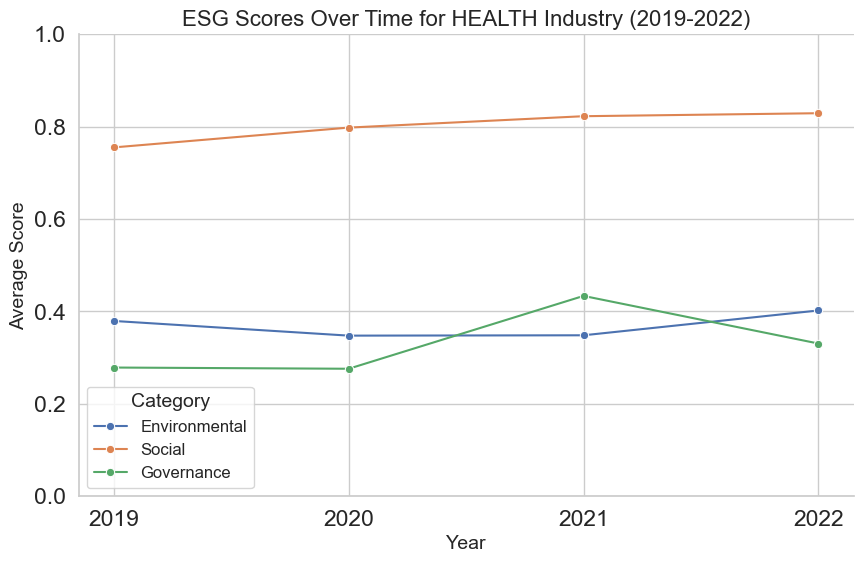

In [ ]:
data = {
    "Year": list(target_years),
    "Environmental": environment_scores,
    "Environmental_SD": environment_stds,
    "Social": social_scores,
    "Social_SD": social_stds,
    "Governance": governance_scores,
    "Governance_SD": governance_stds
}

df = pd.DataFrame(data)

df_melted = df.melt(
    id_vars=["Year"],
    value_vars=["Environmental", "Social", "Governance"],
    var_name="Category",
    value_name="Score"
)

std_melted = df.melt(
    id_vars=["Year"],
    value_vars=["Environmental_SD", "Social_SD", "Governance_SD"],
    var_name="Category",
    value_name="Standard_Deviation"
)

std_melted["Category"] = std_melted["Category"].str.replace("_SD", "")

df_melted = df_melted.merge(std_melted, on=["Year", "Category"], how="left")

sns.set(style="whitegrid", font_scale=1.5)
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=df_melted,
    x="Year",
    y="Score",
    hue="Category",
    style=None,
    markers=True,
    marker='o',  
    errorbar=None
)

sns.despine(top=True, right=True)

plt.xticks(ticks=df["Year"], labels=df["Year"])
plt.ylim(0, 1)

plt.title(f"ESG Scores Over Time for {industry} Industry (2019-2022)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Score", fontsize=14)
plt.legend(title="Category", title_fontsize=14, fontsize=12)

plt.show()

csv_file_path = f"../Edgar/10K_URL_{industry}/ESG_Scores_{industry}.csv"
df.to_csv(csv_file_path, index=False)

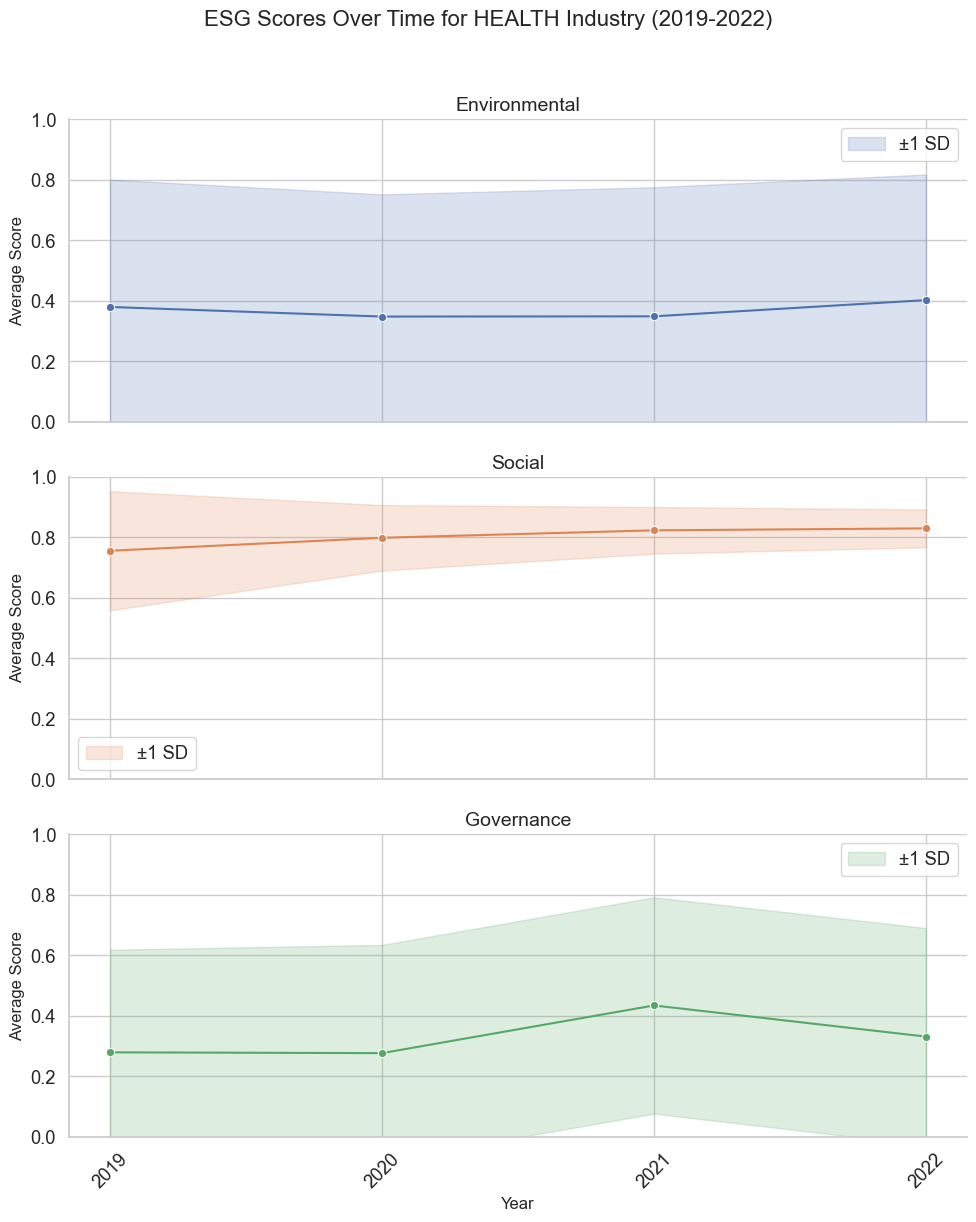

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(style="whitegrid", font_scale=1.2)

fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

categories = ["Environmental", "Social", "Governance"]
colors = sns.color_palette()[:3]

for i, category in enumerate(categories):
    ax = axes[i]
    
    subset = df[["Year", category, f"{category}_SD"]]
    
    sns.lineplot(
        data=subset,
        x="Year",
        y=category,
        ax=ax,
        marker='o',
        color=colors[i]
    )
    
    ax.fill_between(
        subset["Year"],
        subset[category] - subset[f"{category}_SD"],
        subset[category] + subset[f"{category}_SD"],
        color=colors[i],
        alpha=0.2,
        label="±1 SD"
    )
    
    ax.set_title(f"{category}", fontsize=14)
    ax.set_ylabel("Average Score", fontsize=12)
    ax.set_xlabel("Year", fontsize=12)
    
    ax.set_ylim(0, 1)
    ax.legend()
    
    sns.despine(ax=ax, top=True, right=True)

axes[-1].set_xticks(df["Year"])
axes[-1].set_xticklabels(df["Year"], rotation=45)

fig.suptitle(f"ESG Scores Over Time for {industry} Industry (2019-2022)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()